# Portfolio Value at Risk and Conditional Value at Risk

Sourced from Quantopian Lecture Series (Jonathan Larkin and Delaney Granizo-Mackenzie)

In [1]:
import numpy as np
import pandas as pd
import math

from scipy.stats import norm
import time

import matplotlib.pyplot as plt

import yfinance as yf



# Risk Measures
#from nonNormalReturnsOptimization.riskMeasurments.VaR import *


Get all symbols of S&P500

In [2]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
symbols = df['Symbol'].values.tolist()
names = df['Security'].values.tolist()

Get Real Estate Symbols

In [3]:
#show unique economy sectors
sectors = df['GICS Sector'].values.tolist()
sectors = set(sectors)

real_estate_df = df[df['GICS Sector'] == 'Real Estate']
real_estate_symbols = real_estate_df['Symbol'].values.tolist()

In [7]:
tickers = real_estate_symbols[:5]
num_stocks = len(tickers)

start = time.time()
data = yf.download(tickers, start='2015-08-01', end='2020-08-01', period = "1d")
price_data = data['Adj Close']
end = time.time()
print("Time: %0.2f seconds." % (end - start))

[*********************100%***********************]  5 of 5 completed
Time: 0.58 seconds.


In [8]:
df_returns_data = pd.read_csv('Data.csv', index_col=0)
return_data = df_returns_data
df_returns_hf = pd.read_csv('Data_HF - Copy.csv', index_col=0).dropna()
return_data = df_returns_hf
#num_stocks = return_data

## General Functions

In [11]:
def convert_price_to_return(price_data):
    """
    Converts Price Data to Returns
    :param return_data: dataframe of returns of portfolio assets
    :return: returns minimum variance portfolio
    """
    portfolioAssets = price_data.head()
    
    return_data = pd.DataFrame()
    # Calculate Returns for Every Asset
    for asset in portfolioAssets:
        return_data[str(asset)] = (price_data[asset] - price_data[asset].shift(1)) / price_data[asset].shift(1)
    
    # Drop first row of Returns
    return_data = return_data.drop(return_data.index[0])
    return_data = return_data.dropna()
    return return_data

In [12]:
# Convert Price Data to Returns
return_data = convert_price_to_return(price_data)
return_data

,AIV,AMT,ARE,AVB,BXP
Date,,,,,
2015-08-04,-0.001522,0.007970,-0.008812,-0.007587,-0.013392
2015-08-05,-0.009144,0.005410,-0.008676,-0.001564,-0.014143
2015-08-06,0.003332,0.017798,-0.003565,0.002262,-0.002803
2015-08-07,0.004855,0.013115,0.004229,0.006251,-0.006449
2015-08-10,-0.002797,0.008429,-0.004859,-0.000518,-0.003578
...,...,...,...,...,...
2020-07-27,0.003085,0.015527,0.010739,-0.007695,-0.010367
2020-07-28,0.034396,0.024932,0.020134,0.031018,0.015602
2020-07-29,0.021087,0.016829,0.013062,0.008919,-0.005926


In [13]:
def calculate_port_return(weights, mu):
    """
    Calculates the return of the portfolio
    :param weights: weight vector defining allocation between assets in portfolio
                mu: vector of historical returns of portfolio
    :return: returns return of portfolio
    """
    return np.dot(np.transpose(weights), mu)

In [14]:
def calculate_historical_returns(return_data):
    """
    Calculates the Mu matrix for the securities
    :param return_data: the data frame containing the returns
    :return: returns an array containing the arithmetic average return
    """
    return np.array(return_data.mean())

In [15]:
def calculate_port_variance(weights, Sigma):
    """
    Calculates the variance of returns of the portfolio
    :param weights: weight vector defining allocation between assets in portfolio
             sigma: covariance matrix of portfolio returns
    :return: returns variance of portfolio
    """
    return np.dot(np.dot(np.transpose(weights), Sigma), weights)

## MVO Funcations

In [16]:
def calculate_gmv(return_data):
    """
    Calculates Minimum Variance Portfolio
    :param return_data: dataframe of returns of portfolio assets
    :return: returns minimum variance portfolio
    """
    # Preliminary Calculations
    numAssets = len(return_data.columns)
    mu = calculate_historical_returns(return_data)
    Sigma = return_data.cov().to_numpy()
    
    # Create B Matrix
    b = np.zeros( (numAssets+1, 1) )
    
    # Set Initial Constraint (w'1 = 1)
    b[numAssets, 0] = 1
    
    # Create A Matrix
    A = np.zeros( (numAssets+1, numAssets+1) )
    A[0:numAssets, 0:numAssets] = 2*Sigma
    A[numAssets,0:numAssets] = np.ones( (1,numAssets) )
    A[0:numAssets,numAssets] = np.ones( (1,numAssets) )
    
    # Solve for x
    x = np.dot(np.linalg.inv(A), b)
    
    # Calculate Minimum Variance Portfolio
    weights = x[0:numAssets]
    erp = calculate_port_return(weights, mu)
    sigmarp = math.sqrt(calculate_port_variance(weights, Sigma))
    minVarPort = (float(erp), float(sigmarp))
    
    return minVarPort

In [17]:
def calculate_MVE(return_data, mu0):
    """
    Calculates Minimum Variance Portfolio Given Level of Return
    :param return_data: dataframe of returns of portfolio assets
    :return: returns minimum variance portfolio given level of return
    """
    # Preliminary Calculations
    numAssets = len(return_data.columns)
    mu = calculate_historical_returns(return_data)
    Sigma = return_data.cov().to_numpy()
    
    # Create B Matrix
    b = np.zeros( (numAssets+2, 1) )
    
    # Set Initial Constraints (w'1 = 1), (E(rp)=mu0)
    b[numAssets, 0] = 1
    b[numAssets+1, 0] = mu0
    
    A = np.zeros( (numAssets+2, numAssets+2) )
    A[0:numAssets, 0:numAssets] = 2*Sigma
    A[numAssets,0:numAssets] = np.ones( (1,numAssets) )
    A[0:numAssets,numAssets] = np.ones( (1,numAssets) )
    A[numAssets+1,0:numAssets] = mu
    A[0:numAssets,numAssets+1] = mu
    
    # Solve for x
    x = np.dot(np.linalg.inv(A), b)
    
    # Calculate Efficient Portfolio
    weights = x[0:numAssets]
    erp = calculate_port_return(weights, mu)
    sigmarp = math.sqrt(calculate_port_variance(weights, Sigma))
    efficentPortfolio = (float(erp), float(sigmarp))
    
    return efficentPortfolio

In [18]:
def calculate_EF(return_data, gmvPort, mu0Increment=.001, mu0Itterations=25):
    """
    Calculates Efficient Frontier
    :param return_data: dataframe of returns of portfolio assets
    :return: returns efficent frontier of portfolio
    """
    EF = [[],[]]
    
    for mu0 in np.arange(gmvPort[0], mu0Itterations*mu0Increment + gmvPort[0], mu0Increment):
        efficentPortfolio = calculate_MVE(return_data, mu0)
        EF[0].append(efficentPortfolio[0])
        EF[1].append(efficentPortfolio[1])
        
    return EF

## VaR Functions

In [19]:
def calculate_value_at_risk(weights, return_data, alpha=0.95, lookback_days=520):
    # Calculate Weighted Portfolio Returns
    portfolio_returns = return_data.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha))

In [20]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))

calculate_value_at_risk(weights, return_data, alpha=0.95)

-0.02773580832836208

## MVO

In [21]:
# Calculate Minimum Variance Portfolio
minVarPort = calculate_gmv(return_data)

In [22]:
EF = calculate_EF(return_data, minVarPort, mu0Increment=.001, mu0Itterations=25)

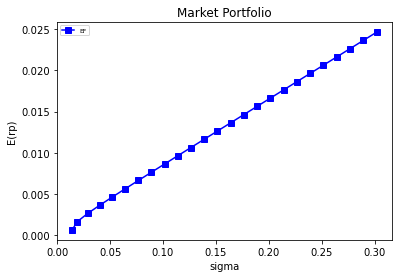

In [23]:
# Plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(EF[1], EF[0], linestyle='-', c='b', marker="s", label='EF')
plt.legend(loc='upper left', prop={'size': 6});
plt.title('Market Portfolio')
plt.xlabel('sigma')
plt.ylabel('E(rp)')
#plt.savefig('marketPortfolioOptimization.png')
plt.show()

## VaR

### Normal Case

$VaR_{\alpha}(x) = \mu - \sigma N^{-1}\alpha$

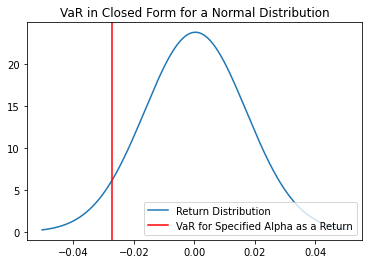

In [24]:
# SD of Portfolio
Sigma = return_data.cov().to_numpy()
port_SD = float(np.sqrt(calculate_port_variance(weights, Sigma)))
mu = calculate_historical_returns(return_data)
port_returns = float(calculate_port_return(weights, mu))

def value_at_risk_N(mu=0, sigma=1.0, alpha=0.95):
    return mu - sigma*norm.ppf(alpha)

x = np.linspace(-3*port_SD,3*port_SD,1000)
y = norm.pdf(x, loc=port_returns, scale=port_SD)
plt.plot(x,y);
plt.axvline(value_at_risk_N(mu = port_returns, sigma = port_SD, alpha=0.95), color='red', linestyle='solid');
plt.legend(['Return Distribution', 'VaR for Specified Alpha as a Return'],loc='lower right')
plt.title('VaR in Closed Form for a Normal Distribution');

## Historical (Non-Parametric Case)

## Underlying Distributions Are Not Always Normal

In [25]:
weights

array([0.66384578, 0.09005226, 0.04506117, 0.0748499 , 0.1261909 ])

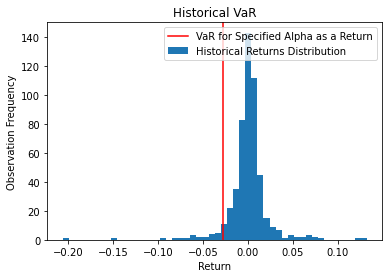

In [26]:
lookback_days = 520
alpha = 0.95

#portfolio_returns = return_data.iloc[-lookback_days:].dot(weights)
portfolio_VaR = calculate_value_at_risk(weights, return_data, alpha=alpha, lookback_days=lookback_days)
#plt.hist(portfolio_returns, bins=50)
portfolio_returns = return_data.iloc[-lookback_days:].dot(weights)
plt.hist(portfolio_returns, bins=50)
plt.axvline(portfolio_VaR, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

In [27]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print('The portfolio returns are likely normal.')
else:
    print('The portfolio returns are likely not normal.')

The portfolio returns are likely not normal.


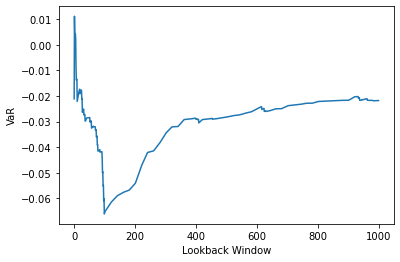

In [28]:
N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = calculate_value_at_risk(weights, return_data, alpha=alpha, lookback_days=i)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

Because the non-parametric historical VaR depends on the lookback window, it is important to pick a lookback window where the VaR converges.

In [29]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print('Process is likely stationary.')
else:
    print('Process is likely non-stationary.')

Process is likely stationary.


## CVaR

CVaR is what many consider an improvement on VaR, as it takes into account the shape of the returns distribution. It is an expectation over all the different possible losses greater than VaR and their corresponding estimated likelihoods.

$$CVaR_{\alpha}(x) \approx \frac{1}{(1-\alpha)} \int_{f(x,y) \geq VaR_{\alpha}(x)} f(x,y)p(y)dy dx$$

In [30]:
def calculate_conditional_value_at_risk(weights, return_data, alpha=.95, lookback_days=520):
    # Call out to our existing function
    var = calculate_value_at_risk(weights, return_data, alpha=alpha, lookback_days=lookback_days)
    portfolio_returns = return_data.iloc[-lookback_days:].dot(weights)
    
    return np.nanmean(portfolio_returns[portfolio_returns < var])

# Jason's Version (Same result as mine (less -c_var))
def calculate_conditional_value_at_risk2(weights, return_data, alpha=95, lookback_days=520):
    w = np.array(weights)
    portfolio_returns = return_data.iloc[-lookback_days:].dot(weights)

    portfolio_returns_sorted = np.sort(portfolio_returns, axis=0)
    n_returns = len(portfolio_returns_sorted)
    confidence_index = round(((100 - alpha) * 0.01) * n_returns)
    c_var = (1 / confidence_index) * portfolio_returns_sorted[:confidence_index].sum()
    return c_var

In [31]:
portfolio_CVaR = calculate_conditional_value_at_risk(weights, return_data, alpha=alpha, lookback_days=lookback_days)
print(portfolio_CVaR)
portfolio_CVaR = calculate_conditional_value_at_risk2(weights, return_data, alpha=95, lookback_days=520)
print(portfolio_CVaR)

-0.05737125290169964
-0.05737125290169964


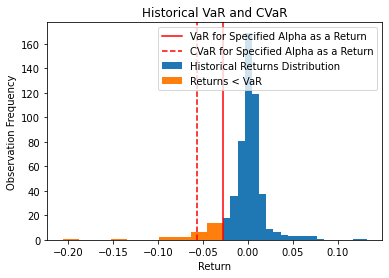

In [32]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = return_data.iloc[-lookback_days:].dot(weights)

portfolio_VaR = calculate_value_at_risk(weights, return_data, alpha=alpha, lookback_days=lookback_days)

portfolio_CVaR = calculate_conditional_value_at_risk(weights, return_data, alpha=alpha, lookback_days=lookback_days)

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR], bins=10)
plt.axvline(portfolio_VaR, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

<ipython-input-30-dce60c437e26>:6: RuntimeWarning: Mean of empty slice
  return np.nanmean(portfolio_returns[portfolio_returns < var])


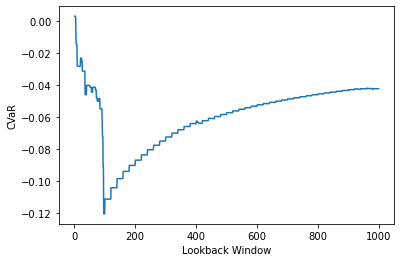

In [33]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = calculate_conditional_value_at_risk(weights, return_data, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('CVaR');

## Optimization

In [34]:
import scipy.optimize

def constraint_return_level(weights, mu, return_level):
    """
    Constraint stating that the product of weights and returns should equal the mu null value
    :param weights: array of weights for the portfolio
    :param mu: matrix of all the returns for all securities
    :param return_level: the specified return of the portfolio
    :return: returns the return of the portfolio minus the return level value
    """
    port_retrun = np.dot(np.transpose(weights), mu)
    return port_retrun - return_level

def constraint_weight_sum(weights):
    """
    Constraint stating that all weights must sum to one
    :param w: the array of weights for the portfolio
    :return: returns the sum of weights minus one
    """
    return sum(weights) - 1

def efficient_weights_cvar(return_data, return_level, confidence, lookback_days=520):
    mu = return_data.mean()

    cons = [{'type': 'eq', 'fun': constraint_weight_sum},
            {'type': 'eq', 'fun': constraint_return_level, 'args': (mu, return_level)}]

    minimizer_kwargs = {"args": (return_data, confidence, lookback_days),
                        "constraints": cons}

    optimize = scipy.optimize.basinhopping(calculate_conditional_value_at_risk,
                                           x0=np.full((len(return_data.columns)), 1 / len(return_data.columns)),
                                           minimizer_kwargs=minimizer_kwargs)
    return optimize.x

In [36]:
return_level = .0001
confidence = 0.95
eff_weights = efficient_weights_cvar(return_data, return_level, confidence)
print(eff_weights)
print(efficient_weights_cvar(eff_weights))
print()

[ 86700474.07528938 -18191877.97893082  -7188071.89850602
 -26351015.04326639 -34969508.15458615]


## Monte Carlo Simulation

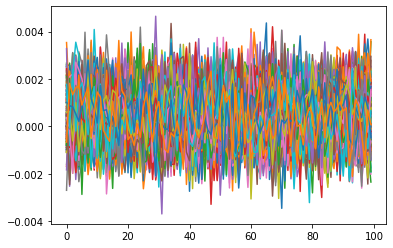

In [317]:
mu = 0.0005
vol = 0.001
T = 252
sim_returns = []
for i in range(100):
    rand_rets = np.random.normal(mu,vol,T)
    sim_returns.append(rand_rets)

plt.plot(range(100), sim_returns)